In [1]:
import numpy as np
from numpy import radians
from lib.cartpolesystem import CartPoleSystem, Cart, Pole
from lib.motors import StepperMotor
from lib.cartpoleenv import CartPoleEnv
from lib.direct_collocation import CartPoleStepperMotorDirectCollocation
from lib.regulators import LQR
from time import perf_counter
from matplotlib import pyplot as plt
from lib.numerical import rk4_step

In [18]:
dt = 0.005
g = 9.81
r = 0.04456
x_max = 0.8
m = 0.2167
J = 0.0001
d = 0.001

cart = Cart(m, 0.01, (-x_max, x_max), 0.2)
motor = StepperMotor(r, (-2.7, 2.7), 0.1, (-5, 5), 0.1)
poles = [Pole(0.045, 0.15, 0.075, d, J),Pole(0.045, 0.2, 0.1, d, J)]
system = CartPoleSystem(cart, motor, poles, g)

n = system.num_poles

max_time = 10
N_env = int(max_time/dt)

env = CartPoleEnv(system, dt, rk4_step)
env.observation_space.shape

(6,)

Optimizing trajectory...
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2244
Number of nonzeros in inequality constraint Jacobian.:      126
Number of nonzeros in Lagrangian Hessian.............:      756

Total number of variables............................:      441
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      384
Total number of inequality constraints...............:      126
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      126
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.67e+00 0.00e+00  -1.0 0.00e+00

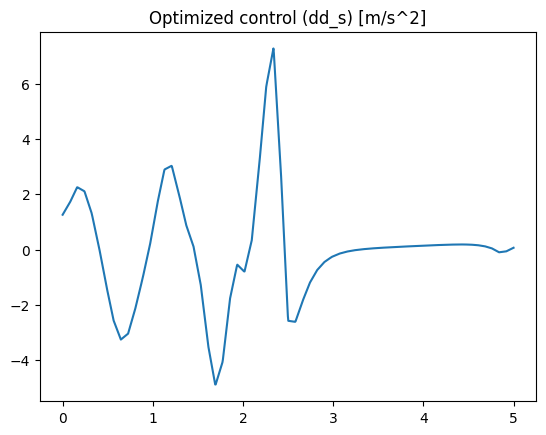

In [29]:
end_time = 5
dt_collocation = 0.05
N_collocation = int(end_time/dt_collocation)+1

N = int(end_time/dt)

direct_collocation = CartPoleStepperMotorDirectCollocation(N, N_collocation, system, 0.0001)

x0 = np.array([0, 0] + [radians(180), 0]*n)

r = np.array([-0.2, 0] + [radians(0), 0]*n)

print("Optimizing trajectory...")
states, controls = direct_collocation.make_solver(end_time, x0, r)

time = np.linspace(0, end_time, N)

plt.title("Optimized control (dd_s) [m/s^2]")
plt.plot(time, controls.T[0])
plt.show()

In [30]:
np.set_printoptions(precision=2)

linearization_x0 = np.zeros(2+2*n)
linearization_u0 = np.array([0])

A0, B0 = system.linearize(linearization_x0, linearization_u0)

C = np.diag([1, 1]+[1, 1]*n)

D = np.zeros((1, 1))

ct_dt = dt

Q = np.diag([100, 10]+[100, 10]*n)
R = np.diag([1])

A_d0, B_d0 = LQR.discretize(ct_dt, A0, B0, C, D)
_, K_d0 = LQR.calculate_K_d(A_d0, B_d0, Q, R)

print("A:", A0)
print("B:", B0)
K_d0

A: [[   0.      1.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      1.      0.      0.  ]
 [   0.      0.    184.89   -6.01 -100.85    4.15]
 [   0.      0.      0.      0.      0.      1.  ]
 [   0.      0.   -226.91    9.19  204.03   -6.91]]
B: [[ 0.  ]
 [ 1.  ]
 [ 0.  ]
 [ 8.57]
 [ 0.  ]
 [-2.33]]


array([[   8.65,    9.81,  250.96,    0.36, -291.47,  -17.34]])

In [31]:
print("Calculating As and Bs...")
As, Bs = np.vectorize(system.linearize, signature='(n),(m)->(n,n),(n,m)')(states, controls)

Calculating As and Bs...


In [32]:
print("Calculating A_ds and B_ds...")
A_ds, B_ds = np.vectorize(LQR.discretize, signature='(),(n,n),(n,m),(a,b),(c,d)->(n,n),(n,m)')(ct_dt, As, Bs, C, D)
print("Calculating K_ds...")
_, K_ds = LQR.calculate_finite_K_ds(A_ds, B_ds, Q, R)

Calculating A_ds and B_ds...
Calculating K_ds...


In [33]:
print("Memory usage K_ds: ", (K_ds.nbytes)/1024**1, "KB")

Memory usage K_ds:  46.875 KB


In [34]:
last_update = perf_counter()

state, _ = env.reset(x0)

errors = np.zeros((N_env, 2+2*n))
feedback_controls = np.zeros((N_env, 1))  

final_state = states[-1]

for i in range(N_env-1):
    while perf_counter() < last_update + dt:
        pass
    last_update = perf_counter()

    error = np.zeros(2+2*n)
    if i < N*1:
        error = system.calculate_error(state, states[i])
        u_ff = controls[i]
        u_fb = LQR.feedback(K_ds[i], error)
        u = u_ff + u_fb
        feedback_controls[i] = u_fb
    else:
        error = system.calculate_error(state, final_state)
        u = LQR.feedback(K_ds[-1], error)
    errors[i] = error

    state, reward, done, msg, _ = env.step(u)
    env.render()

env.close()

AttributeError: 'NoneType' object has no attribute 'fill'

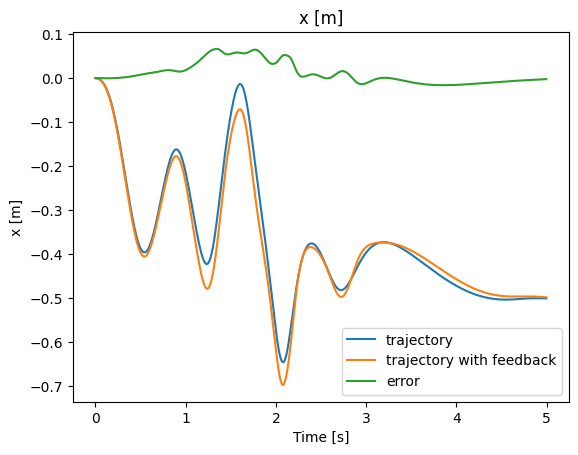

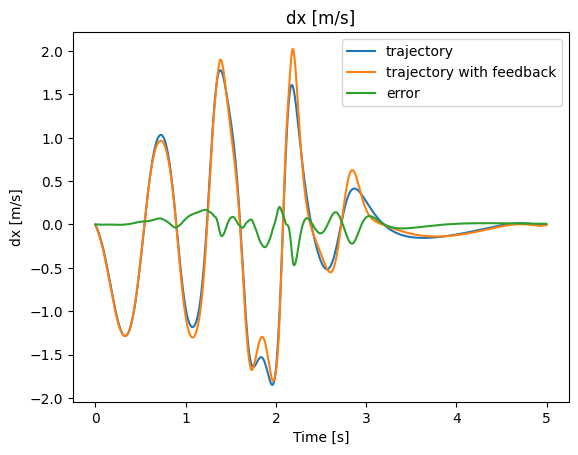

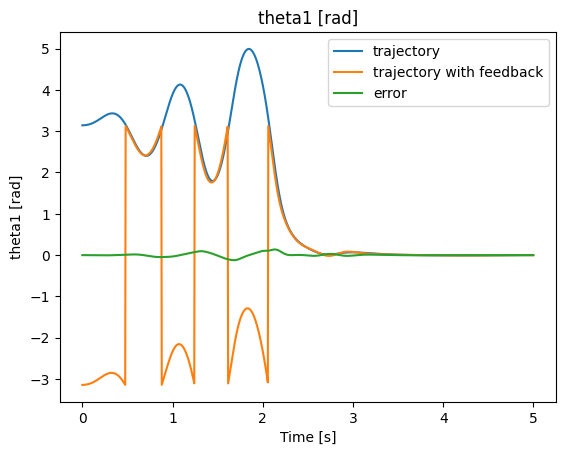

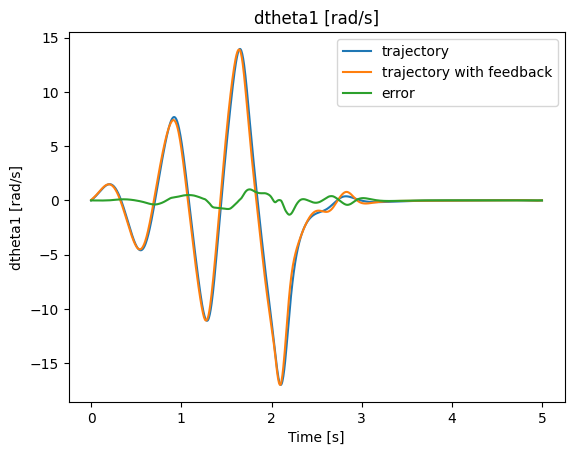

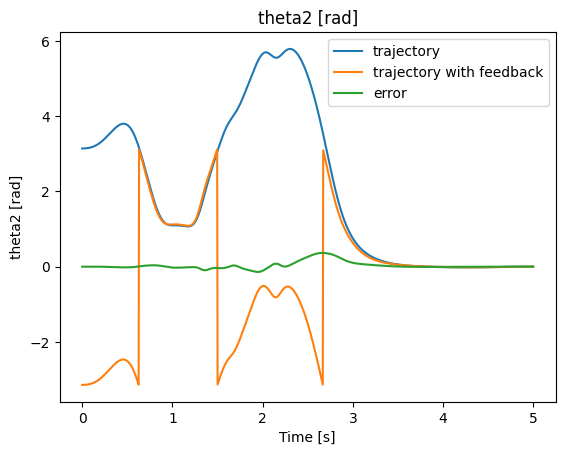

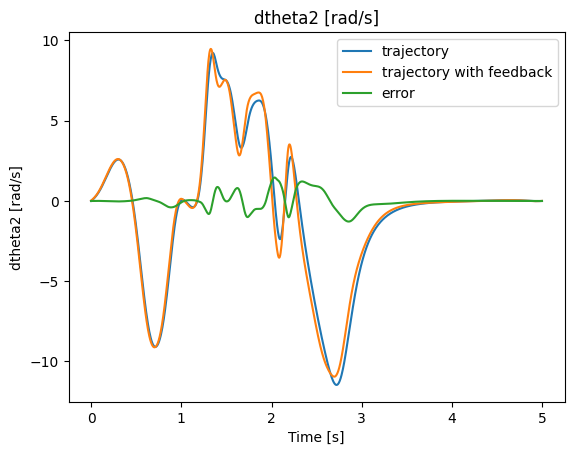

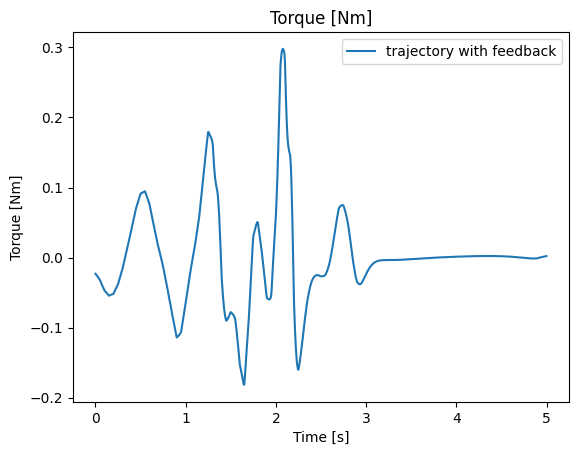

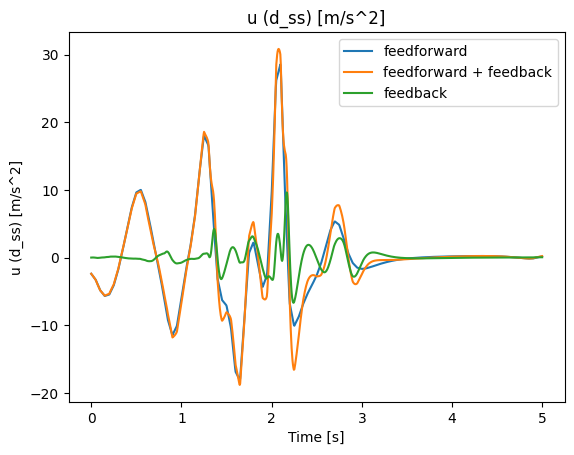

In [ ]:
time = np.linspace(0, max_time, N_env)
state_labels = ["x [m]", "dx [m/s]", "theta1 [rad]", "dtheta1 [rad/s]", "theta2 [rad]", "dtheta2 [rad/s]", "theta3 [rad]", "dtheta3 [rad/s"]
for i in range(system.num_states):
    plt.xlabel("Time [s]")
    plt.ylabel(state_labels[i])
    plt.title(state_labels[i])
    plt.plot(time[:N], states.T[i][:N], label="trajectory")
    plt.plot(time[:N], np.array(env.states).T[i][1:N+1], label="trajectory with feedback")
    plt.plot(time[:N], errors.T[i][:N], label="error")
    plt.legend()
    plt.show()

constrain_labels = ["Torque [Nm]"]
for i in range(system.num_constraint_states):
    plt.xlabel("Time [s]")
    plt.ylabel(constrain_labels[i])
    plt.title(constrain_labels[i])
    plt.plot(time[:N], np.array(env.constraint_states).T[i][1:N+1], label="trajectory with feedback")
    plt.legend()
    plt.show()

plt.title("u (d_ss) [m/s^2]")
plt.xlabel("Time [s]")
plt.ylabel("u (d_ss) [m/s^2]")
plt.plot(time[:N], controls.T[0][:N], label="feedforward")
plt.plot(time[:N], np.array(env.controls).T[0][1:N+1], label="feedforward + feedback")
plt.plot(time[:N], feedback_controls.T[0][:N], label="feedback")
plt.legend()
plt.show()